In [1]:
import numpy as np
import healpy as hp
import pickle
from matplotlib.pyplot import *
import tqdm
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import maptools
import constant as c
import cmb
# others
import local
import tools_cmb
import tools_multitracer as mass
import warnings
warnings.filterwarnings("ignore")

In [2]:
# define parameters
lmax  = 190     # maximum multipole of alm to be generated
NSIDE = 128
NPIX = 12*NSIDE**2
l = np.linspace(0,lmax,lmax+1)
fac = l*(l+1)/2/np.pi*c.Tcmb**2
wl = hp.sphtfunc.pixwin(NSIDE,lmax=lmax)
bl = cmb.beam(80.,lmax,inv=False)

### Read galaxy survey mask

In [8]:
pobj = local.analysis()
cobj = tools_cmb.cmb_map()

In [9]:
M = hp.ud_grade(hp.read_map('../data/lensing/FG_mask.fits'),NSIDE)
W = cs.utils.apodize(NSIDE, M, 1.)
#W = M.copy()
fsky = np.mean(M)
W2 = np.mean(W**2)
print(W2,fsky)

0.46264096931410165 0.48342980941136676


In [37]:
rlz = 2
iQs, iUs = hp.read_map(pobj.ficmb[rlz],field=(1,2))/c.Tcmb

In [38]:
iElm, iBlm = cs.utils.hp_map2alm_spin(hp.get_nside(iQs),lmax,lmax,2,iQs,iUs)

In [15]:
rlm = pickle.load(open(cobj.fralm[rlz],"rb"))[:lmax+1,:lmax+1]
Qr, Ur = cs.utils.hp_alm2map_spin(NSIDE,lmax,lmax,2,0*rlm,rlm)
Qr, Ur = tools_cmb.qumap_smoothing(Qr,Ur,lmax,NSIDE,bl)

In [17]:
Qs, Us = tools_cmb.qumap_smoothing(iQs,iUs,lmax,NSIDE,bl)

In [18]:
Elm, Blm = cs.utils.hp_map2alm_spin(NSIDE,lmax,lmax,2,Qs,Us)
sBB = cs.utils.alm2cl(lmax,Blm)

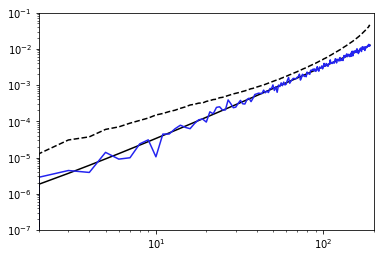

In [19]:
xlim(2,200)
ylim(1e-7,1e-1)
loglog(l,fac*pobj.lcl[2,:lmax+1],label='lensing',color='k',ls='-')
loglog(l,fac*sBB/wl**2/bl**2)
loglog(l,fac*pobj.clfg[:lmax+1],label='noise',color='k',ls='--')

In [20]:
Qn = hp.ud_grade(hp.read_map(pobj.ffgs[rlz],field=1)/c.Tcmb,NSIDE)
Un = hp.ud_grade(hp.read_map(pobj.ffgs[rlz],field=2)/c.Tcmb,NSIDE)

In [21]:
data = np.array(((Qs+Qn)*M,(Us+Un)*M)).reshape((2,1,NPIX))
invN = np.array((M,M)).reshape((2,1,NPIX))
inls = np.array((1./pobj.clfg[:lmax+1],1./pobj.clfg[:lmax+1])).reshape(2,1,lmax+1)
kwargs_cinv = {
    'chn':  1, \
    'eps':  [1e-4], \
    'itns': [1000], \
    'ro':   10, \
    'inl':  inls, \
    'stat': 'status.txt' \
}
Bl = np.array((bl*wl)).reshape((1,lmax+1))
wElm, wBlm = cs.cninv.cnfilter_freq(2,1,NSIDE,lmax,pobj.lcl[1:3,:lmax+1],Bl,invN,data,**kwargs_cinv)

In [22]:
data = np.array(((Qr)*M,(Ur)*M)).reshape((2,1,NPIX))
invN = np.array((M,M)).reshape((2,1,NPIX))
inls = np.array((1./pobj.clfg[:lmax+1],1./pobj.clfg[:lmax+1])).reshape(2,1,lmax+1)
kwargs_cinv = {
    'chn':  1, \
    'eps':  [1e-4], \
    'itns': [1000], \
    'ro':   10, \
    'inl':  inls, \
    'stat': 'status.txt' \
}
Bl = np.array((bl*wl)).reshape((1,lmax+1))
rElm, rBlm = cs.cninv.cnfilter_freq(2,1,NSIDE,lmax,pobj.lcl[1:3,:lmax+1],Bl,invN,data,**kwargs_cinv)

In [39]:
EE = cs.utils.alm2cl(lmax,wElm)
BB = cs.utils.alm2cl(lmax,wBlm)
bb = cs.utils.alm2cl(lmax,rBlm)
xB = cs.utils.alm2cl(lmax,wBlm,iBlm)
iB = cs.utils.alm2cl(lmax,iBlm)

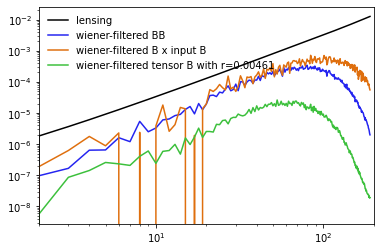

In [40]:
xlim(2,200)
loglog(l,fac*pobj.lcl[2,:lmax+1],label='lensing',color='k',ls='-')
loglog(l,fac*BB/fsky,label='wiener-filtered BB')
loglog(l,fac*xB/fsky,label='wiener-filtered B x input B')
loglog(l,fac*.00461*bb/fsky,label='wiener-filtered tensor B with r=0.00461')
#loglog(l,pobj.lcl[2,:lmax+1]**2/(pobj.lcl[2,:lmax+1]+pobj.clfg[:lmax+1]),label='approx',color='k',ls='--')
legend(loc=2)

In [35]:
sn = np.sqrt(fsky*np.sum((l[2:]+.5)*(1e-3*bb[2:]/BB[2:])**2))
print(sn)

0.9468098254979259


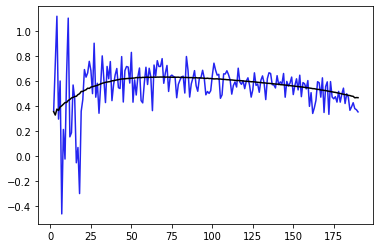

In [41]:
plot(xB/np.sqrt(fsky*BB*iB))
plot(np.sqrt(pobj.lcl[2,:lmax+1]/(pobj.lcl[2,:lmax+1]+pobj.clfg[:lmax+1])),color='k',label='--')